In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Data

In [32]:
# Load data
pvc = pd.read_excel('PVC-Teste.xls', sheet_name='Price History', index_col=[0], parse_dates=[0])

pvc.head()

,PVC BRL/tonne
Date,
2001-05-11,1842.534
2001-05-18,1813.952
2001-05-25,1902.516
2001-06-01,1922.032
2001-06-08,1899.295


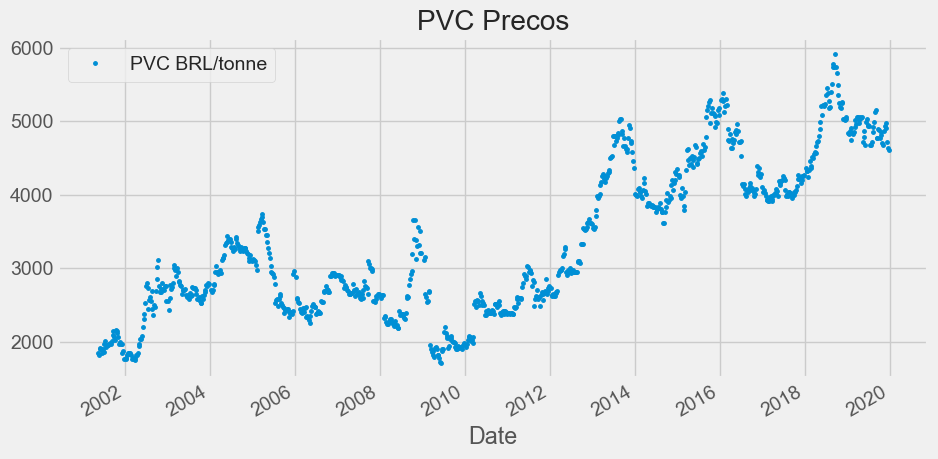

In [33]:
color_pal = sns.color_palette()
pvc.plot(style='.',
          figsize=(10, 5),
          ms=5,
          color=color_pal[0],
          title='PVC Precos')
plt.show()

In [34]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pvc, label='PVC BRL/tonne')
features_and_target = pd.concat([X, y], axis=1)


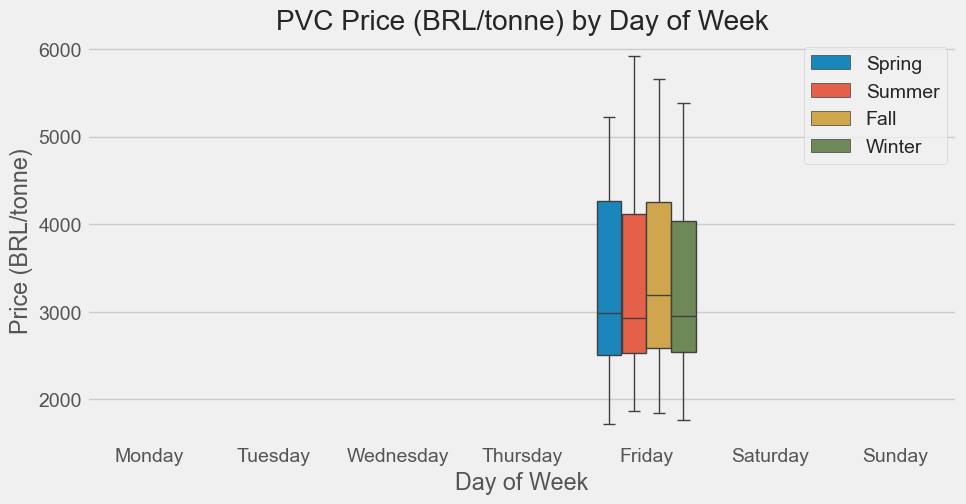

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',  # Assuming your weekday column is named 'weekday'
            y='PVC BRL/tonne',  # Replace with your actual price column name
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('PVC Price (BRL/tonne) by Day of Week')  # Adjust title as needed
ax.set_xlabel('Day of Week')
ax.set_ylabel('Price (BRL/tonne)')  # Adjust y-axis label
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

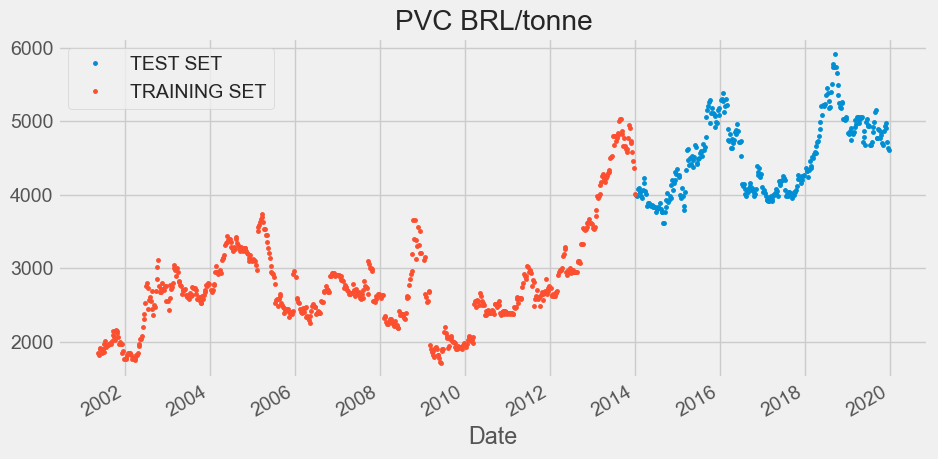

In [36]:
split_date = '2014-01-03'

pvc_train = pvc.loc[pvc.index <= split_date].copy()
pvc_test = pvc.loc[pvc.index > split_date].copy()

pvc_test \
    .rename(columns={'PVC BRL/tonne': 'TEST SET'}) \
    .join(pvc_train.rename(columns={'PVC BRL/tonne': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PVC BRL/tonne', style='.', ms=5)
plt.show()


Simple Prophet Model¶ 
Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model. Datetime column named: ds target : y

In [37]:
# Format data for prophet model using ds and y
pvc_train_prophet = pvc_train.reset_index() \
    .rename(columns={'Date':'ds',
                     'PVC BRL/tonne':'y'})

In [38]:
%%time
model = Prophet()
model.fit(pvc_train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: total: 359 ms
Wall time: 665 ms


In [39]:
# Predict on test set with model
pvc_test_prophet = pvc_test.reset_index() \
    .rename(columns={'Date':'ds',
                     'PVC BRL/tonne':'y'})

pvc_test_fcst = model.predict(pvc_test_prophet)

In [40]:
pvc_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-10,4653.345520,4191.165382,4984.718167,4653.345520,4653.345520,-60.814413,-60.814413,-60.814413,-60.814413,-60.814413,-60.814413,0.0,0.0,0.0,4592.531107
1,2014-01-17,4669.039279,4213.316754,4995.380551,4669.039279,4669.039279,-67.211284,-67.211284,-67.211284,-67.211284,-67.211284,-67.211284,0.0,0.0,0.0,4601.827996
2,2014-01-24,4684.733039,4205.706962,4978.237830,4684.733039,4684.733039,-75.771985,-75.771985,-75.771985,-75.771985,-75.771985,-75.771985,0.0,0.0,0.0,4608.961054
3,2014-01-31,4700.426799,4235.099112,5045.345383,4700.426799,4700.426799,-74.385329,-74.385329,-74.385329,-74.385329,-74.385329,-74.385329,0.0,0.0,0.0,4626.041470
4,2014-02-07,4716.120558,4262.917379,5055.259900,4716.120558,4716.120558,-58.059965,-58.059965,-58.059965,-58.059965,-58.059965,-58.059965,0.0,0.0,0.0,4658.060593


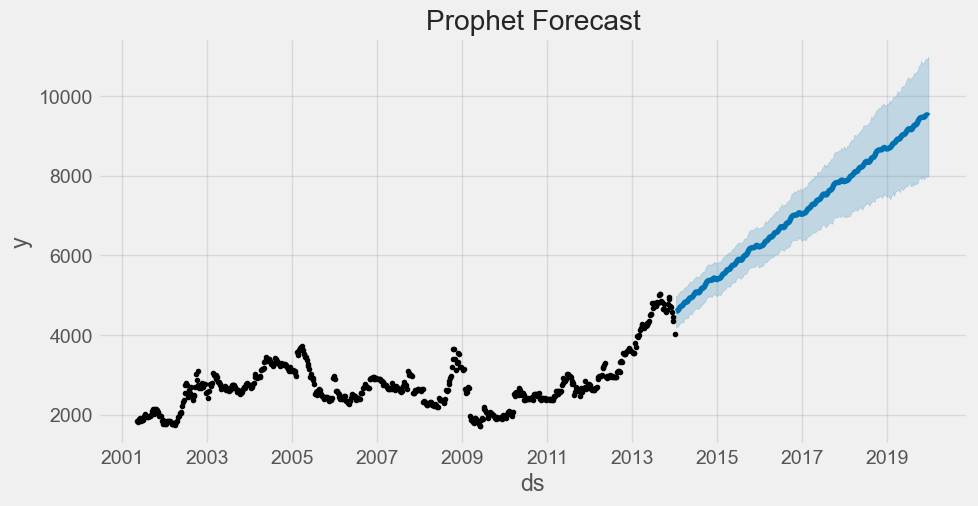

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pvc_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

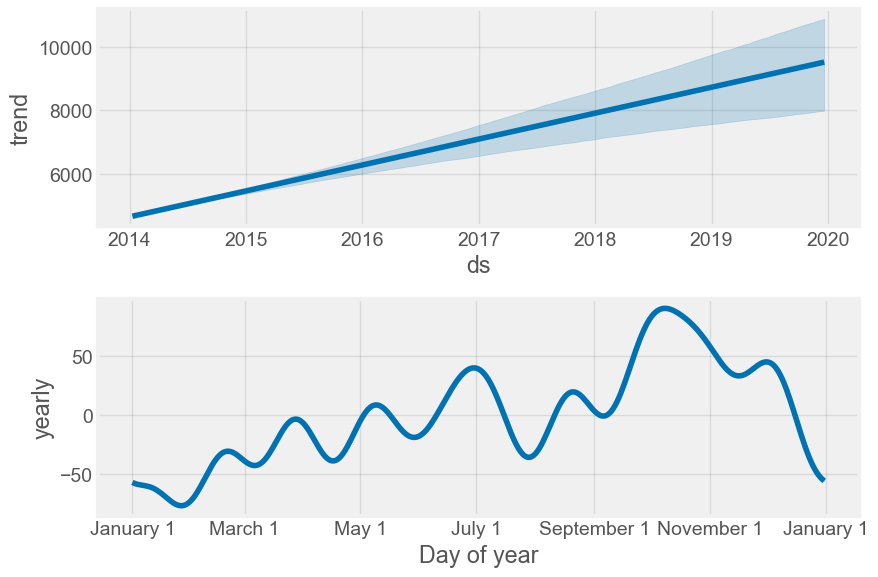

In [42]:
fig = model.plot_components(pvc_test_fcst)
plt.show()

Compare Forecast to Actuals¶

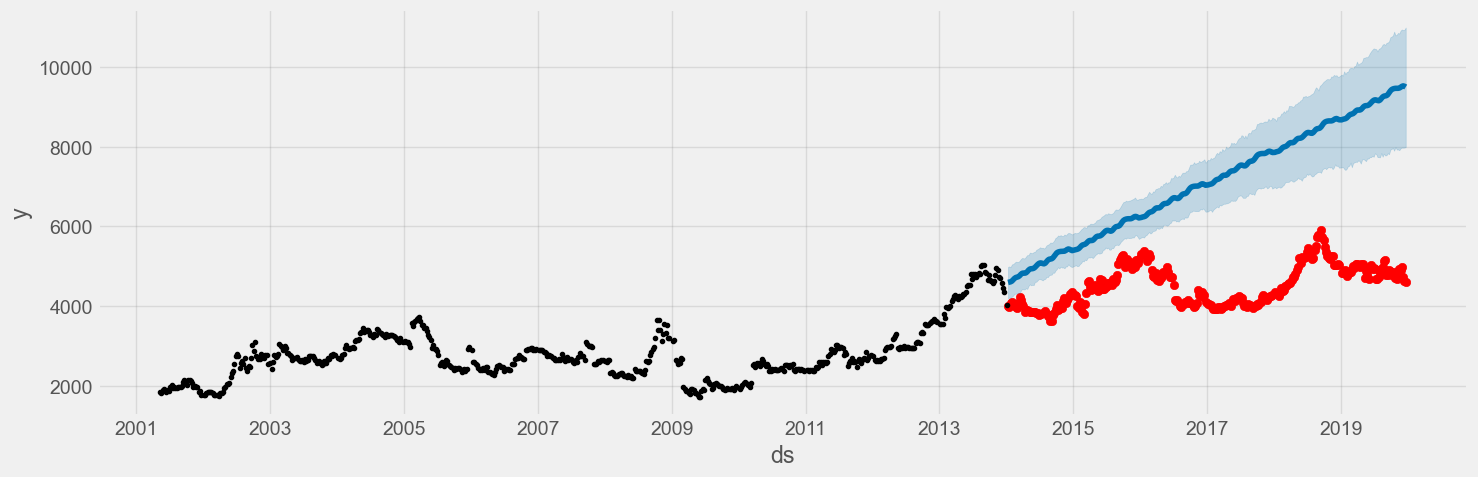

In [43]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pvc_test.index, pvc_test['PVC BRL/tonne'], color='r')
fig = model.plot(pvc_test_fcst, ax=ax)

ConversionError: Failed to convert value(s) to axis units: '2012-01-06'

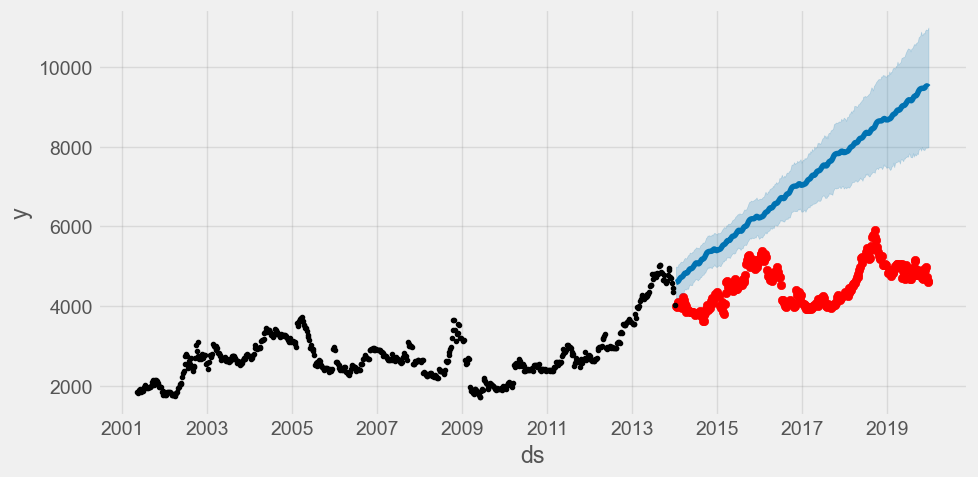

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pvc_test.index, pvc_test['PVC BRL/tonne'], color='r')
fig = model.plot(pvc_test_fcst, ax=ax)
ax.set_xbound(lower='2012-01-06',
              upper='2017-12-22')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Forecast vs Actuals')